In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pandas as pd

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

In [3]:
import cmocean

In [4]:
import graphufs
from graphufs.spatialmap import SpatialMap
plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [82]:
ds = xr.open_zarr("/p1-evaluation/v1/long-forecasts/graphufs.2019-01-01T00.8754h.zarr/")
sds = xr.open_zarr("/p1-evaluation/v1/long-forecasts/graphufs.2019-01-01T00.8754h.spectra.zarr/")
sds = sds.sortby("latitude")
#eds = xr.open_dataset("/p1-evaluation/v1/long-forecasts/graphufs_vs_era5_8754h_deterministic_temporal.nc")

In [12]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        ds.time.isel(time=0).values,
        ds.time.isel(time=-1).values
    ),
    level=[100,500,850],
)

In [13]:
era

<xarray.Dataset> Size: 2TB
Dimensions:                                           (time: 8749,
                                                       latitude: 721,
                                                       longitude: 1440, level: 3)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 24B 100 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 70kB ...
Data variables: (12/48)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ...                                                ...
    v_component_of_wind                               (time, level, latitude, longitude) float32 109GB dask.array<chunksize=(1, 3, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 109GB dask.array<chunksize=(1, 3, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 36GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

In [83]:
sds.load();

In [33]:
xx = sds.surface_pressure.mean("latitude")

In [49]:
from matplotlib.colorbar import ColorbarBase

[Text(0, 0.5, 'Zonal PSD'),
 Text(0.5, 0, 'Zonal Wavenumber'),
 Text(0.5, 1.0, '10m U Component of Wind')]

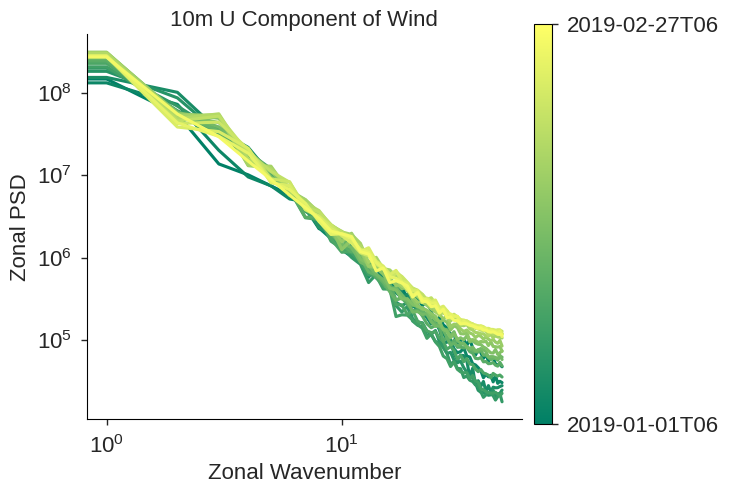

In [108]:
fig, ax = plt.subplots(figsize=(6,5))

cmap = "summer"
timesel = sds.time.values[::12]
n_time = len(timesel)

for i, time in enumerate(timesel):
    plotme = sds["10m_u_component_of_wind"]
    plotme = plotme.sortby("latitude").sel(latitude=slice(55, 80))
    plotme = plotme.mean("latitude")
    plotme = plotme.isel(time=i)
    plotme.plot(
        ax=ax,
        yscale="log",
        xscale="log",
        color=plt.get_cmap(cmap)(int(i/n_time * 256)),
    )
fig.subplots_adjust(right=.85)
cax = fig.add_axes([.87, .1, .03, .8])
cbar = ColorbarBase(cax, cmap=plt.get_cmap(cmap), orientation="vertical", ticks=[0, 1])
cbar.ax.set_yticklabels([str(t)[:13] for t in [timesel[0], timesel[-1]]])

ax.set(
    ylabel="Zonal PSD",
    xlabel="Zonal Wavenumber",
    title="10m U Component of Wind",
)

In [101]:
class SpatialMap():
    defaults = {
        "tmp2m": {
            "vmax": 30,
            "vmin": -10,
            "cmap": "cmo.thermal",
            "label": "2m Temperature ($^\circ$C)",
        },
        "10m_wind_speed": {
            "vmax": 25,
            "vmin": 0,
            "cmap": "cmo.speed",
            "label": "10m Horizontal Wind Speed (m/s)",
        },
    }

    central_longitude = -80
    central_latitude = 20

    def __init__(self, **kwargs):

        for key, val in kwargs.items():
            try:
                getattr(self, key)
                setattr(self, key, val)
            except:
                print(f"No attr {key}, ignoring kwarg")

    @staticmethod
    def get_figsize(ncols):
        return (5*ncols, 6)

    @staticmethod
    def get_extend(xdslist, vmin, vmax):
        minval = np.min([xds.min().values for xds in xdslist])
        maxval = np.max([xds.max().values for xds in xdslist])
        vmin = minval if vmin is None else vmin
        vmax = maxval if vmax is None else vmax

        extend = "neither"
        if minval < vmin:
            extend = "min"
        if maxval > vmax:
            extend = "max" if extend == "neither" else "both"

        return extend, vmin, vmax
    

    def plot(self, gda, tda, date, subselect=False, **kwargs):

        # select in time
        gda = gda.sel(time=date)
        tda = tda.sel(time=date)

        if subselect:
            tda = tda.isel(latitude=slice(None, None, 4), longitude=slice(None, None, 4))
        
        fig, axs = plt.subplots(
            1,2,
            figsize=self.get_figsize(2),
            constrained_layout=True,
            subplot_kw={
                "projection": ccrs.Orthographic(
                    central_longitude=self.central_longitude,
                    central_latitude=self.central_latitude,
                ),
            },
        )
        for key in ["vmax", "vmin", "cmap"]:
            if key not in kwargs and gda.name in self.defaults.keys():
                kwargs[key] = self.defaults[gda.name][key]
                
        if gda.name in self.defaults.keys():
            label = self.defaults[gda.name]["label"]
        else:
            label = f"{gda.name} ({tda.attrs['units']})"

        if gda.name == "tmp2m":
            gda = gda - 273.15
            tda = tda - 273.15

        extend, kwargs["vmin"], kwargs["vmax"] = self.get_extend([gda, tda], kwargs["vmin"], kwargs["vmax"])
        kw = {"transform": ccrs.PlateCarree(), "add_colorbar": False, **kwargs}
                
        p = gda.plot(ax=axs[0], **kw)
        tda.plot(ax=axs[1], x="longitude", **kw)
        
        [ax.add_feature(cf.COASTLINE) for ax in axs];
        axs[0].set(title=f"GraphUFS, {str(date)[:13].replace(' ', 'T')}")
        axs[1].set(title=f"ERA5, {str(date)[:13].replace(' ', 'T')}");
        fig.colorbar(p, ax=axs, orientation="horizontal", shrink=.6, aspect=35, label=label, extend=extend)
        return fig, axs
    

In [102]:
mapper = SpatialMap()

In [103]:
ds["10m_wind_speed"] = np.sqrt(ds["ugrd10m"]**2 + ds["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

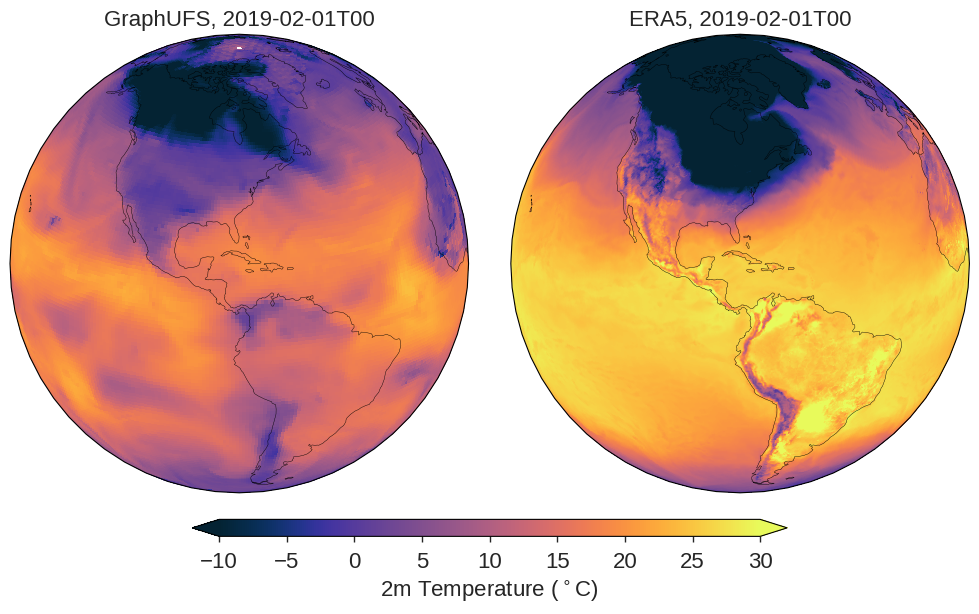

In [105]:
mapper.plot(
    ds["tmp2m"],
    era["2m_temperature"],
    date="2019-02-01T00",
);

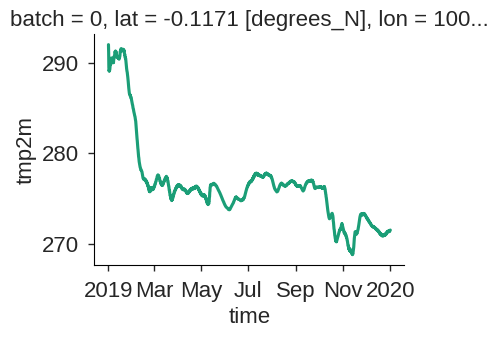

In [18]:
ds.tmp2m.squeeze().sel(lat=0, lon=100, method="nearest").plot()

In [22]:
np.isnan(ds.tmp2m.sel(lat=0, lon=100, method="nearest")).any().values

array(False)

In [24]:
ds = ds.drop_vars("batch")

In [25]:
ds

<xarray.Dataset> Size: 36GB
Dimensions:     (time: 1459, level: 13, lat: 192, lon: 384)
Coordinates:
  * lat         (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * level       (level) float32 52B 47.81 97.82 145.7 ... 847.8 921.9 998.8
  * lon         (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
    lead_time   (time) timedelta64[ns] 12kB 0 days 06:00:00 ... 364 days 18:0...
  * time        (time) datetime64[ns] 12kB 2019-01-01T06:00:00 ... 2019-12-31...
Data variables:
    delz        (time, level, lat, lon) float32 6GB dask.array<chunksize=(183, 2, 24, 96), meta=np.ndarray>
    dzdt        (time, level, lat, lon) float32 6GB dask.array<chunksize=(183, 2, 24, 96), meta=np.ndarray>
    prateb_ave  (time, lat, lon) float32 430MB dask.array<chunksize=(183, 24, 96), meta=np.ndarray>
    pressfc     (time, lat, lon) float32 430MB dask.array<chunksize=(183, 24, 96), meta=np.ndarray>
    spfh        (time, level, lat, lon) float32 6GB dask.array<chunksize=(183, 2, 24, 96), meta=np.ndarray>
    tmp         (time, level, lat, lon) float32 6GB dask.array<chunksize=(183, 2, 24, 96), meta=np.ndarray>
    tmp2m       (time, lat, lon) float32 430MB dask.array<chunksize=(183, 24, 96), meta=np.ndarray>
    ugrd        (time, level, lat, lon) float32 6GB dask.array<chunksize=(183, 2, 24, 96), meta=np.ndarray>
    ugrd10m     (time, lat, lon) float32 430MB dask.array<chunksize=(183, 24, 96), meta=np.ndarray>
    vgrd        (time, level, lat, lon) float32 6GB dask.array<chunksize=(183, 2, 24, 96), meta=np.ndarray>
    vgrd10m     (time, lat, lon) float32 430MB dask.array<chunksize=(183, 24, 96), meta=np.ndarray>